# BNB Linked Data Platform

The [BNB Linked Data Platform](https://bnb.data.bl.uk/) provides access to the [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) published as linked open data and made available through SPARQL services. 

This notebook explains how to query the repository and obtain places of publication (fields blt:publication and blt:projectedPublication ) to show an interactive map. Thanks that the works are linked to [GeoNames](https://www.geonames.org/), the records can be linked to external repositories. This notebook  obtains information from [Wikidata](https://www.wikidata.org), showing the benefits of Linked Open Data.

## Global configuration

In this section, you can set the author from the BNB by using its identifier. 

In [1]:
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/DickensCharles1812-1870'
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/BlakeWilliam1757-1827'
bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/WoolfVirginia1882-1941'
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/ShakespeareWilliam1564-1616'

## Setting up things

In [2]:
import folium
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

## Let's query the repository by asking the publications related to William Shakespeare
We will use the [SPARQL endpoint](https://bnb.data.bl.uk/flint-sparql) to create the query and configure the request to retrieve json as a result.

In [3]:
url = 'https://bnb.data.bl.uk/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX bio: <http://purl.org/vocab/bio/0.1/>
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX isbd: <http://iflastandards.info/ns/isbd/elements/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdau: <http://rdaregistry.info/Elements/u/>
PREFIX madsrdf: <http://www.loc.gov/mads/rdf/v1#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX umbel: <http://umbel.org/umbel#>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?resource ?title ?date ?place WHERE {{
    graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?resource ?p <{0}> ;
         dct:title ?title ;
         schema:datePublished ?date .
      OPTIONAL {{
          ?resource blt:projectedPublication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
      OPTIONAL {{
          ?resource blt:publication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
    }}
}} LIMIT 500
"""

query = query.format(bnbIdAuthor)

# use json as a result
headers = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': query}, headers=headers)
print('Elements retrieved!')
print(r.text)

Elements retrieved!

{ "head": { "link": [], "vars": ["resource", "title", "date", "place"] },
  "results": { "distinct": false, "ordered": true, "bindings": [
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013001764" }	, "title": { "type": "literal", "value": "The years" }	, "date": { "type": "literal", "value": "2004-12" }	, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/019599487" }	, "title": { "type": "literal", "value": "Mrs Dalloway" }	, "date": { "type": "literal", "value": "2020-01" }	, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/017816985" }	, "title": { "type": "literal", "value": "Mrs Dalloway" }	, "date": { "type": "literal", "value": "2016-05" }	, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "re

## Save as a CSV 

In [4]:
bnbdata = json.loads(r.text)

with open('bnb_records.csv', 'w', newline='') as file:
    csv_out = csv.writer(file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    

    #csv_out = csv.writer(open('bnb_records.csv', 'w'), delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    csv_out.writerow(['resource', 'place', 'title', 'date'])

    for i in bnbdata['results']['bindings']:
        resource = place = title = date =''

        resource = i['resource']['value']
        #if "place" in i:
        place = i['place']['value']
        title = i['title']['value']
        date = i['date']['value']

        csv_out.writerow([resource,place,title,date])

## Exploring the data

In [5]:
# Load the CSV file from GitHub.
# This puts the data in a Pandas DataFrame
df = pd.read_csv('bnb_records.csv')

In [6]:
df

,resource,place,title,date
0,http://bnb.data.bl.uk/id/resource/013001764,http://sws.geonames.org/6269131/,The years,2004-12
1,http://bnb.data.bl.uk/id/resource/019599487,http://sws.geonames.org/6269131/,Mrs Dalloway,2020-01
2,http://bnb.data.bl.uk/id/resource/017816985,http://sws.geonames.org/6269131/,Mrs Dalloway,2016-05
3,http://bnb.data.bl.uk/id/resource/015711457,http://sws.geonames.org/6252001/,Mrs Dalloway,2011-04
4,http://bnb.data.bl.uk/id/resource/018460540,http://sws.geonames.org/6269131/,Orlando,2017-10
5,http://bnb.data.bl.uk/id/resource/018460544,http://sws.geonames.org/6269131/,A room of one's own,2017-10
6,http://bnb.data.bl.uk/id/resource/018460549,http://sws.geonames.org/6269131/,Mrs Dalloway,2017-10
7,http://bnb.data.bl.uk/id/resource/018460551,http://sws.geonames.org/6269131/,To the lighthouse,2017-10
8,http://bnb.data.bl.uk/id/resource/018462175,http://sws.geonames.org/6269131/,The illustrated letters of Virginia Woolf,2017-10
9,http://bnb.data.bl.uk/id/resource/018463437,http://sws.geonames.org/6252001/,Monday or Tuesday,2017-08


## How many items?

In [7]:
# How many items?
len(df)

36

### Let's count the number of resources per place

In [8]:
places_by_number = df.groupby("place")["resource"].count()

In [9]:
places_by_number

place
http://sws.geonames.org/6252001/     5
http://sws.geonames.org/6269131/    31
Name: resource, dtype: int64

In [10]:
### We can access the count of each place

In [11]:
places_by_number[['http://sws.geonames.org/6269131/']][0]

31

### Create a chart to visualize the results
This chart shows the number of resources by date.

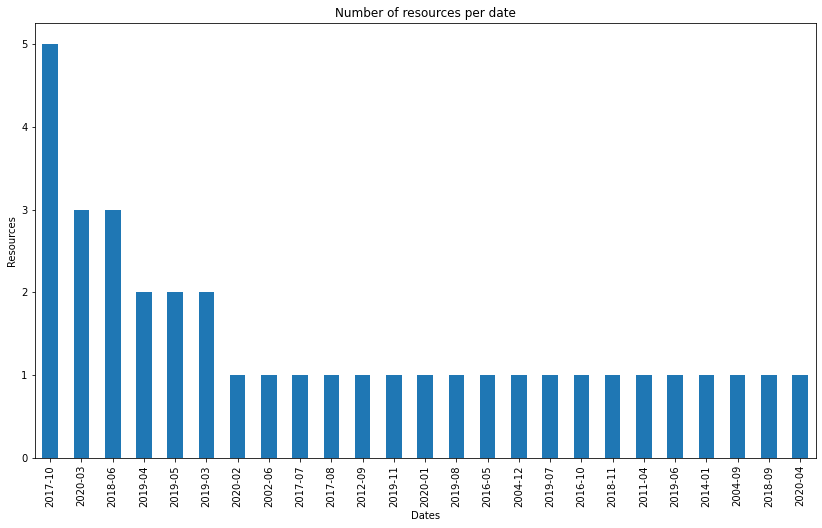

In [12]:
ax = df['date'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

### Let's group the items by year

In [13]:
# First we create a new column in pandas with the year
df['year'] = pd.DatetimeIndex(df['date']).year

In [14]:
df['year']

0     2004
1     2020
2     2016
3     2011
4     2017
5     2017
6     2017
7     2017
8     2017
9     2017
10    2019
11    2019
12    2020
13    2018
14    2018
15    2018
16    2004
17    2014
18    2002
19    2012
20    2017
21    2018
22    2016
23    2019
24    2019
25    2019
26    2019
27    2020
28    2018
29    2019
30    2019
31    2019
32    2019
33    2020
34    2020
35    2020
Name: year, dtype: int64

### Creating the chart by year

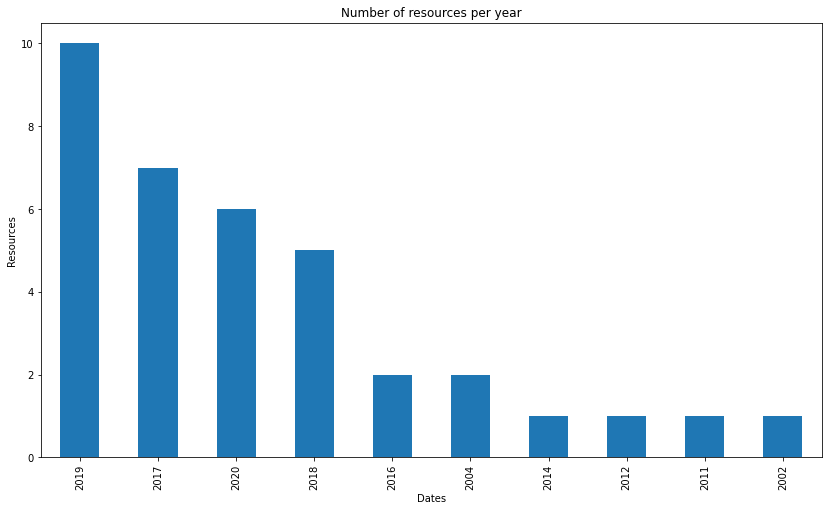

In [15]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per year")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

## Exploring the places

In [16]:
# Get unique values
places = pd.unique(df['place']).tolist()
strplaces = ''
for a in sorted(places):
    print(a)
    strplaces = strplaces + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'

http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/


### Getting latitude and longitude from Wikidata

In [17]:
url = 'https://query.wikidata.org/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

query = query.format(strplaces)
print(query)

# use json as a result
r = requests.get(url, params = {'format': 'json', 'query': query})
geopoints = r.json()


PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE { 
  values ?idgeonames {  "6252001" "6269131" } 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}



### Finally, we add the markers to the map

In [18]:
map = folium.Map(location=[0,0], zoom_start=1.5)

for geo in geopoints['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    label = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = places_by_number[['http://sws.geonames.org/' + idgeonames + '/']][0]
    popup = str(count) + " records published in <a hreh='" + str(idwikidata) + "'>" + label + "</a>"
    
    folium.Marker([lat,lon], popup= popup).add_to(map)

38.895 -77.036666666667
53.0 -1.0


In [19]:
map